# Lab 3 : Diving Into Quantum Algorithms
***

## Section 1: QPE


<img src="./resources/qpe_tex_qz.png" alt="QPE Circuit" style="width: 800px;"/>


As a reminder to you, the above figure outlines the Quantum Phase Estimation (QPE) circuit.  Below, we'll provide a few import statements and functions that you'll use throughout the lab.

In [1]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd

In [2]:
#QFT Circuit
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    return qc

### Step 1: Set up a QPE Circuit with four counting qubits



Let's pick a phase gate with $\theta = \frac{1}{3}$ as a simple example unitary to test creating a QPE circuit.  Here we'll use Qiskit's `PhaseGate` which applies $P|1\rangle{}=e^{i\lambda}|1\rangle{}$.  Since we want to examine QPE under a unitary with the form $U|1\rangle{}=e^{i2\pi \theta}$, we should set $\lambda=\frac{2\pi}{3}$.

Create a QPE circuit with four counting qubits and name the circuit `qpe4`.  It may be helpful to define two `QuantumRegister` objects, one for the "system" where the unitary will be applied and one for where the phase information will be stored.  Feel free to reference the Qiskit Textbook's chapter on [Quantum Phase Estimation](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation#getting_more_precision).

It should look something like this (note that because Qiskit uses little endian notation, the ordering of the controlled-$U$ gates are different):

<img src="./resources/qpe4_circuit.png" alt="QPE 4 Phase Circuit" style="width: 1000px;"/>


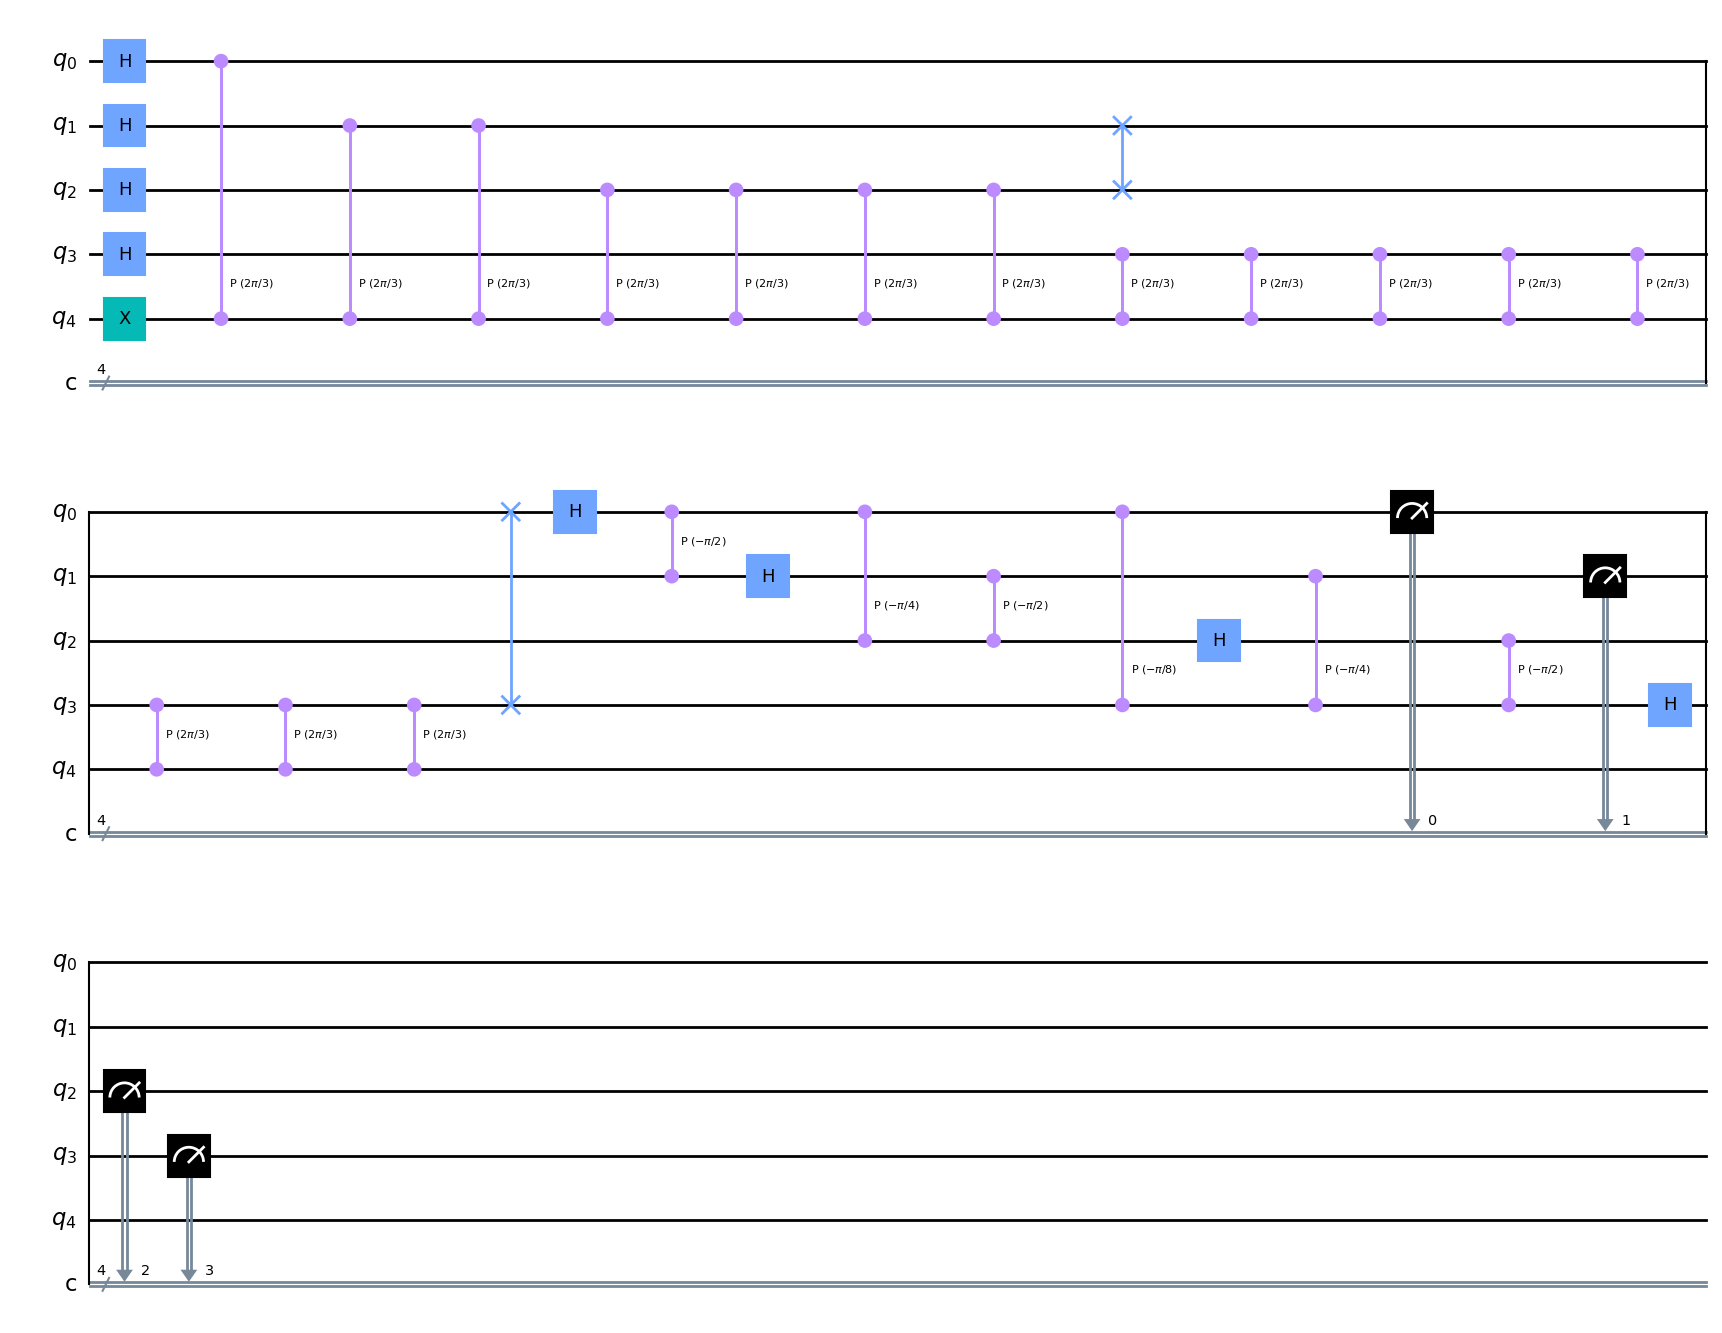

In [3]:

phase_register_size = 4
qpe4 = QuantumCircuit(phase_register_size+1, phase_register_size)

### Insert your code here
# Apply H-Gates to counting qubits:
for qubit in range(4):
    qpe4.h(qubit)
# Prepare our eigenstate |psi>:
qpe4.x(4)
# Do the controlled-U operations:
angle = 2*np.pi/3
repetitions = 1
for counting_qubit in range(4):
    for i in range(repetitions):
        qpe4.cp(angle, counting_qubit, 4);
    repetitions *= 2
qpe4.swap(0, 3)
qpe4.h(0)
qpe4.swap(1, 2)
qpe4.cp(-np.pi/2, 0, 1)
qpe4.h(1)
qpe4.cp(-np.pi/4, 0, 2)
qpe4.cp(-np.pi/2, 1, 2)
qpe4.cp(-np.pi/8, 0, 3)
qpe4.h(2)
qpe4.cp(-np.pi/4, 1, 3)
qpe4.measure(0,0)
qpe4.cp(-np.pi/2, 2, 3)
qpe4.measure(1,1)
qpe4.h(3)
qpe4.measure(2,2)
qpe4.measure(3,3)
qpe4.draw()

Now use the `AerSimulator` to simulate this circuit and plot the histogram of the results.  Use 2000 shots.


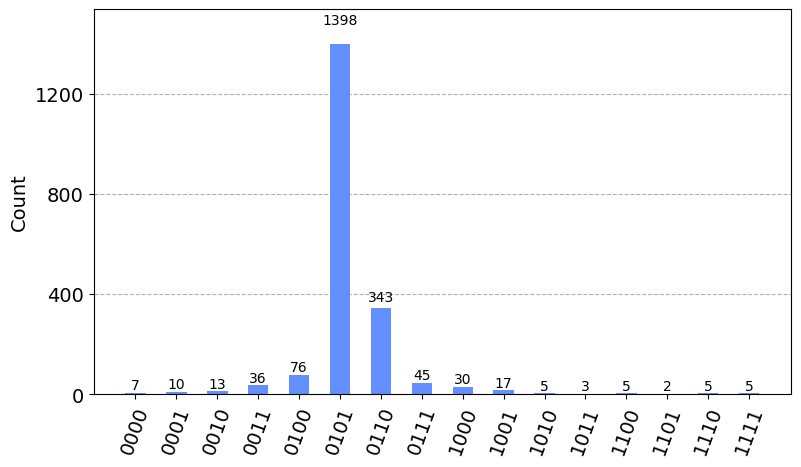

In [4]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 2000
count_qpe4 = execute(qpe4, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

In [5]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex1 

grade_lab3_ex1(count_qpe4)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Next write a function to process the bit strings into the estimate of $\theta$.  Recall that the phase estimate is written in the form:

$$ \theta = 0.\theta_1\theta_2\theta_3...\theta_t = \frac{\theta_1}{2^1} + \frac{\theta_2}{2^2} + \frac{\theta_3}{2^3} + ... + \frac{\theta_t}{2^t} $$

where $\theta_i = \{0,1\}$.  What is the estimated phase?  What is the highest power of 2 this circuit can be accurate up to given your choice of the number of counting qubits (e.g. $2^{-2}$, $2^{-3}$, $2^{-4}$, etc.)?



Estimated Phase: 0.3125
Phase Accuracy Window: 0.0625


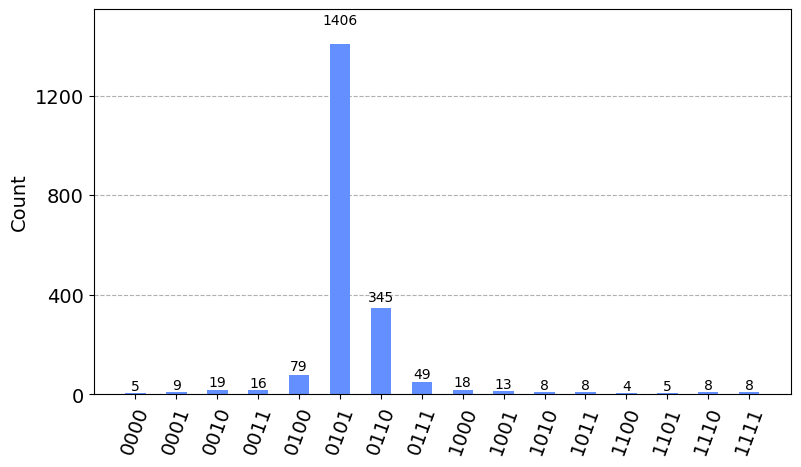

In [6]:
def binary_to_decimal(binary_str):
    decimal_val = int(binary_str, 2)
    return decimal_val
sim = Aer.get_backend('aer_simulator')
shots = 2000
count_qpe4 = execute(qpe4, sim, shots=shots).result().get_counts()

# Find the binary string with the highest probability
max_binary_val = max(count_qpe4, key=count_qpe4.get)

# Convert the binary measurement result to decimal
decimal_val = binary_to_decimal(max_binary_val)

# Calculate the estimated phase
estimated_phase = decimal_val / (2 ** phase_register_size)

# Calculate the phase accuracy window
phase_accuracy_window = 1 / (2 ** phase_register_size)
print("Estimated Phase:", estimated_phase)
print("Phase Accuracy Window:", phase_accuracy_window)

# Plot the histogram of the result
plot_histogram(count_qpe4, figsize=(9, 5))

In [7]:

from qc_grader.challenges.qgss_2023 import grade_lab3_ex2 

grade_lab3_ex2([estimated_phase, phase_accuracy_window])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 2: Run on Noisy Hardware

Now run this circuit using your favorite backend!  Transpile this circuit a number of times (you pick how many) and pick the one with the lowest and highest circuit depth. 

Transpile the circuit with the parameter optimization_level = 3 to reduce the error in the result. Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the transpiled circuit results even under the same runtime settings. Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile qpe4 multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well to compare against, name them `min_depth_qpe` and `max_depth_qpe`.



In [8]:
from qiskit_ibm_provider import IBMProvider 
from qiskit.compiler import transpile 
   

provider = IBMProvider()
hub = "summer-school-1"
group = "group-9"
project = "6758258679"
backend_name = "ibmq_manila"

backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

# your code goes here
# Transpile the circuit multiple times with optimization_level=3

max_depth_qpe = transpile(qpe4,backend)   
min_depth_qpe = transpile(qpe4,backend,optimization_level=3)

print("Circuit with Minimum Depth:")
print(min_depth_qpe.draw())

print("Circuit with Maximum Depth:")
print(max_depth_qpe.draw())

Circuit with Minimum Depth:
Figure(2263.23x2290.94)
Circuit with Maximum Depth:
Figure(2263.23x2876.22)


In [9]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex3

grade_lab3_ex3([max_depth_qpe, min_depth_qpe])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [10]:
shots = 2000

#OPTIONAL: Run the minimum depth qpe circuit
job_min_qpe4 = backend.run(min_depth_qpe, sim, shots=shots)
print(job_min_qpe4.job_id())

#Gather the count data
count_min_qpe4 = job_min_qpe4.result().get_counts()
plot_histogram(count_min_qpe4, figsize=(9,5))

cj570qgl9m0cicsnibe0


KeyboardInterrupt: 

In [ ]:

#OPTIONAL: Run the maximum depth qpe circuit
job_max_qpe4 = backend.run(max_depth_qpe, sim, shots=shots)
print(job_max_qpe4.job_id())

#Gather the count data
count_max_qpe4 = job_max_qpe4.result().get_counts()
plot_histogram(count_max_qpe4, figsize=(9,5))

## Step 3: Try with a different $\theta$

Now try the same procedure with $\theta = \frac{1}{7}$.  Rewrite your code written above to create a function which generates a QPE circuit with $n$ register qubits.  How many register qubits storing the phase information are needed for the estimate to be accurate to within $2^{-6}$? 

*Hint: It may be easier to iterate over different phase register sizes by creating a callable function. Perhaps call it* `qpe_circuit`

In [ ]:
def binary_to_decimal(binary_str):
    decimal_val = int(binary_str, 2)
    return decimal_val

def qpe_circuit(n, theta):
    # Create the quantum circuit
    qpe = QuantumCircuit(n+1, n)

    # Apply H-Gates to counting qubits
    for qubit in range(n):
        qpe.h(qubit)

    # Prepare the eigenstate |psi>
    qpe.x(n)

    # Do the controlled-U operations
    repetitions = 1
    for counting_qubit in range(n):
        for _ in range(repetitions):
            qpe.cp(theta, counting_qubit, n)
        repetitions *= 2

    # Perform inverse QFT
    for qubit in range(n // 2):
        qpe.swap(qubit, n - qubit - 1)

    for j in range(n):
        for m in range(j):
            qpe.cp(-np.pi/float(2**(j-m)), m, j)

        qpe.h(j)

    # Measure counting qubits
    qpe.measure(range(n), range(n))
    
    return qpe

# Define the target phase theta = 1/7
target_phase = 1/7

# Define the desired accuracy (2^(-6))
desired_accuracy = 2**(-6)

# Initialize the register size
num_register_qubits = 1
estimated_phase = 0

# Loop until the desired accuracy is achieved
while True:
    qpe_circuit_instance = qpe_circuit(num_register_qubits, target_phase)
    simulator = Aer.get_backend('aer_simulator')
    shots = 2000
    job_qpe_circuit = execute(qpe_circuit_instance, simulator, shots=shots)
    counts_qpe_circuit = job_qpe_circuit.result().get_counts()
    max_probability_key = max(counts_qpe_circuit, key=counts_qpe_circuit.get)
    estimated_phase = binary_to_decimal(max_probability_key) / (2 ** num_register_qubits)
    
    # Check if the estimated phase is accurate enough
    if abs(estimated_phase - target_phase) < desired_accuracy:
        break

    num_register_qubits += 1

print("Smallest Register Size Needed:", num_register_qubits)

In [ ]:
def binary_to_decimal(binary_str):
    decimal_val = int(binary_str, 2)
    return decimal_val

def qpe_circuit(n, theta):
    # Create the quantum circuit
    qpe = QuantumCircuit(n+1, n)

    # Apply H-Gates to counting qubits
    for qubit in range(n):
        qpe.h(qubit)

    # Prepare the eigenstate |psi>
    qpe.x(n)

    # Do the controlled-U operations
    repetitions = 1
    for counting_qubit in range(n):
        for _ in range(repetitions):
            qpe.cp(theta, counting_qubit, n)
        repetitions *= 2

    # Perform inverse QFT
    for qubit in range(n // 2):
        qpe.swap(qubit, n - qubit - 1)

    for j in range(n):
        for m in range(j):
            qpe.cp(-np.pi/float(2**(j-m)), m, j)

        qpe.h(j)

    # Measure counting qubits
    qpe.measure(range(n), range(n))
    
    return qpe

    



In [ ]:
target_phase = 1/7
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
reg_size = 4 # Vary the register sizes

qpe_check = qpe_circuit(reg_size,target_phase)
sim =  Aer.get_backend('aer_simulator')
shots = 10000
count_qpe4 = execute(qpe_check, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

In [ ]:
# Process the count data to determine accuracy of the estimated phase
max_probability_key = max(count_qpe4, key=count_qpe4.get)
estimated_phase = binary_to_decimal(max_probability_key) / (2 ** reg_size)
print((estimated_phase - target_phase))
print(2**(-6))
print(estimated_phase)
print(binary_to_decimal(max_probability_key))

In [ ]:
required_register_size = 5#your answer here

In [ ]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex4

grade_lab3_ex4(required_register_size)

## Section 2: Shor's Algorithm
***

Here we will construct a set of functions to implement Shor's algorithm.  Remember that the goal of this algorithm is to find the prime factors of some large number $N$ and the key speedup this algorithm provides is by executing the period-finding part using a quantum computer.  This is where this section of the lab will focus.


Shor's algorithm is composed of the following steps:
1. Choose a co-prime $a$, where $a\in [2,N-1]$ and the greatest common divisor of $a$ and $N$ is 1.
1. Find the order (periodicity) of $a$ modulo $N$, i.e. the smallest integer $r$ such that $a^r\text{mod} N=1$
1. Obtain the factor of $N$ by computing the greatest common divisor of $a^{r/2} \pm 1$ and $N$.

## Step 1. Period Finding

To begin, we'll use the unitary operator: $$ U|y\rangle{} \equiv |ay\ \text{mod} N\rangle{} $$


and explore the superposition state: 
$$
|u\rangle{} = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}}|a^k \text{mod}N\rangle{}
$$

Let's pick $a=3$ and $N=35$ as an example and investigate what the action of $U$ is on $|u\rangle{}$
\begin{align}
    U|u\rangle{} &= U\frac{1}{\sqrt{r}}\left( |1\rangle{} + e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} \right) \\
    & =\frac{1}{\sqrt{r}}\left( U|1\rangle{} + e^{-\frac{2\pi i}{r}}U|3\rangle{} + e^{\frac{-4\pi i}{r}}U|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}U|4\rangle{} + e^{\frac{-22\pi i}{r}}U|12\rangle{} \right) \\
    &= \frac{1}{\sqrt{r}}\left( |3\rangle{} + e^{-\frac{2\pi i}{r}}|9\rangle{} + e^{\frac{-4\pi i}{r}}|27\rangle{} + ... + e^{\frac{-20\pi i}{r}}|12\rangle{} + e^{\frac{-22\pi i}{r}}|1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}}\left( e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} + |1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}} |u\rangle{}.
\end{align}


This is a particularly helpful eigenvalue as it contains $r$.  In fact, it needs to be included in order to ensure the phase differences between the basis states are equal.  This is also not the only eigenstate of $U$.  For us to generalize further, we can multiply an integer $s$ to each of these phases, which will then show up in our eigenvalue

\begin{align}
    |u_s\rangle{} &= \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{\frac{-2\pi isk}{r}|a^k\text{mod} N\rangle{}} \\
    U|u_s\rangle{} &= e^{\frac{2\pi is}{r}}|u_s\rangle{}.
\end{align}


Now we have an eigenstate for each integer $0 \leq s \leq r$.  Notably, if we add up all of these eigenstates, the phases cancel all other basis states except $|1\rangle{}$ $$ \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|u_s\rangle{} = |1\rangle{} $$.


Since any state in the computational basis can be written as a linear combination of these eigenstates, if we do QPE on $U$ using the state $|1\rangle{}$, we will measure a phase 

$$ \phi = \frac{s}{r} $$
where $s$ is a random integer between $0$ and $r-1$.  Finally, we can use a method called the continued fraction algorithm on $\phi$ in order to find r.  The final circuit will look something like this



<img src="./resources/Shor_circuit.png" alt="Short Circuit" style="width: 1000px;"/>


***

Below we'll provide the unitary $U$ needed for solving this period finding problem with $a=7$ and $N=15$

$$ 
    U|y\rangle{} = |7y\text{mod}15\rangle{}.
$$

To create $U^x$ we will simply repeat the circuit $x$ times.  The cell below will construct this unitary

In [24]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

Confirm if the operator $U$ works as intended by creating a quantum circuit with $m=4$ qubits.  Prepare the inpute state $|y\rangle{}$ representing any integer between $0$ and $15$ (remembering that Qiskit uses little endian notation) such as $|1\rangle{} = |0001\rangle{}$, $|5\rangle{} = |0101\rangle{}$, etc. and apply $U|y\rangle{}$.  Check if the circuit produces the expected outcomes for several inputs: $|1\rangle{}$, $|2\rangle{}$, and $|5\rangle{}$. (For example, the outcome for input state $|2\rangle{}$ should be $|14\rangle{}=|1110\rangle{}$)  

Run these circuits through the `aer_simulator` backend with $20000$ shots, save the count data as `input_1`, `input_2`, and `input_5`.

In [25]:
### your code goes here

qcirc1 = QuantumCircuit(m)

# Set the input state |y>
input_state = '0001'  # For example, |5> in little-endian notation
for i, bit in enumerate(input_state[::-1]):
    if bit == '1':
        qcirc1.x(i)

# Apply the 7mod15 gate U
qcirc1.append(U, range(m))

# Measure all qubits
qcirc1.measure_all()



In [26]:
qcirc2 = QuantumCircuit(m)

# Set the input state |y>
input_state = '0010'  # For example, |5> in little-endian notation
for i, bit in enumerate(input_state[::-1]):
    if bit == '1':
        qcirc2.x(i)

# Apply the 7mod15 gate U
qcirc2.append(U, range(m))

# Measure all qubits
qcirc2.measure_all()

In [27]:
qcirc3 = QuantumCircuit(m)

# Set the input state |y>
input_state = '0101'  # For example, |5> in little-endian notation
for i, bit in enumerate(input_state[::-1]):
    if bit == '1':
        qcirc3.x(i)

# Apply the 7mod15 gate U
qcirc3.append(U, range(m))

# Measure all qubits
qcirc3.measure_all()

In [28]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000

input_1 = execute(qcirc1, sim, shots=shots).result().get_counts()  # save the count data for input 1

input_2 = execute(qcirc2, sim, shots=shots).result().get_counts()# save the count data for input 2
input_5 = execute(qcirc3, sim, shots=shots).result().get_counts()# save the count data for input 5


In [29]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex5

grade_lab3_ex5([input_1, input_2, input_5])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 2. Implementing $U^{2^{m-1}}$

Now we'll use this controlled-$U$ to estimate the phase $\phi=\frac{s}{r}$.  But first, a quick point to note here.  It turns out a sequence of `7Mod15` gates produce the identity when executed by a multiple of 4 times.  To test this, create a quantum circuit implementing the `7mod15` gate $2^2$ times and run it on the `unitary_simulator` backend to obtain the matrix represenation of the gates in the circuit.  Verify $U^{2^2}=I$.

In [30]:

# Your code goes here

# Define the modulus N and number of qubits m
N = 15
m = int(np.ceil(np.log2(N)))

# Define the 7mod15 gate
U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name = '{}Mod{}'.format(7, N)

# Create a quantum circuit implementing U^22
repetitions = 2**2
unitary_circ = QuantumCircuit(m)
for _ in range(repetitions):
    unitary_circ.append(U, range(m))

# Simulate the unitary circuit using the unitary_simulator backend
sim = Aer.get_backend('unitary_simulator')
unitary = execute(unitary_circ, sim).result().get_unitary()


In [31]:
sim = Aer.get_backend('unitary_simulator')
unitary = execute(unitary_circ, sim).result().get_unitary()

In [32]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex6

grade_lab3_ex6(unitary, unitary_circ)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 3. Finding $\phi$ and Continued Fractions


Now armed with a way to execute $U^{2^{m-1}}$, let's use it in the QPE circuit you created earlier.  Below is a function to construct a controlled-$U$ gate. Use $8$ qubits for the phase register and 4 qubits for the register which $U$ will act on, using the `aer_simulator` again, estimate the phase $\phi$ given an input state of $|1\rangle{}$.

*Hint: at each step in the QPE circuit, you'll need to construct a new `cU_multi` circuit and append it to the QPE circuit. There will be several estimates that have approximately equal probability.*

In [33]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

In [34]:
def cU_multi(k):
    sys_register_size = 4
    circ = QuantumCircuit(sys_register_size)
    for _ in range(2**k):
        circ.append(U, range(sys_register_size))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [35]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

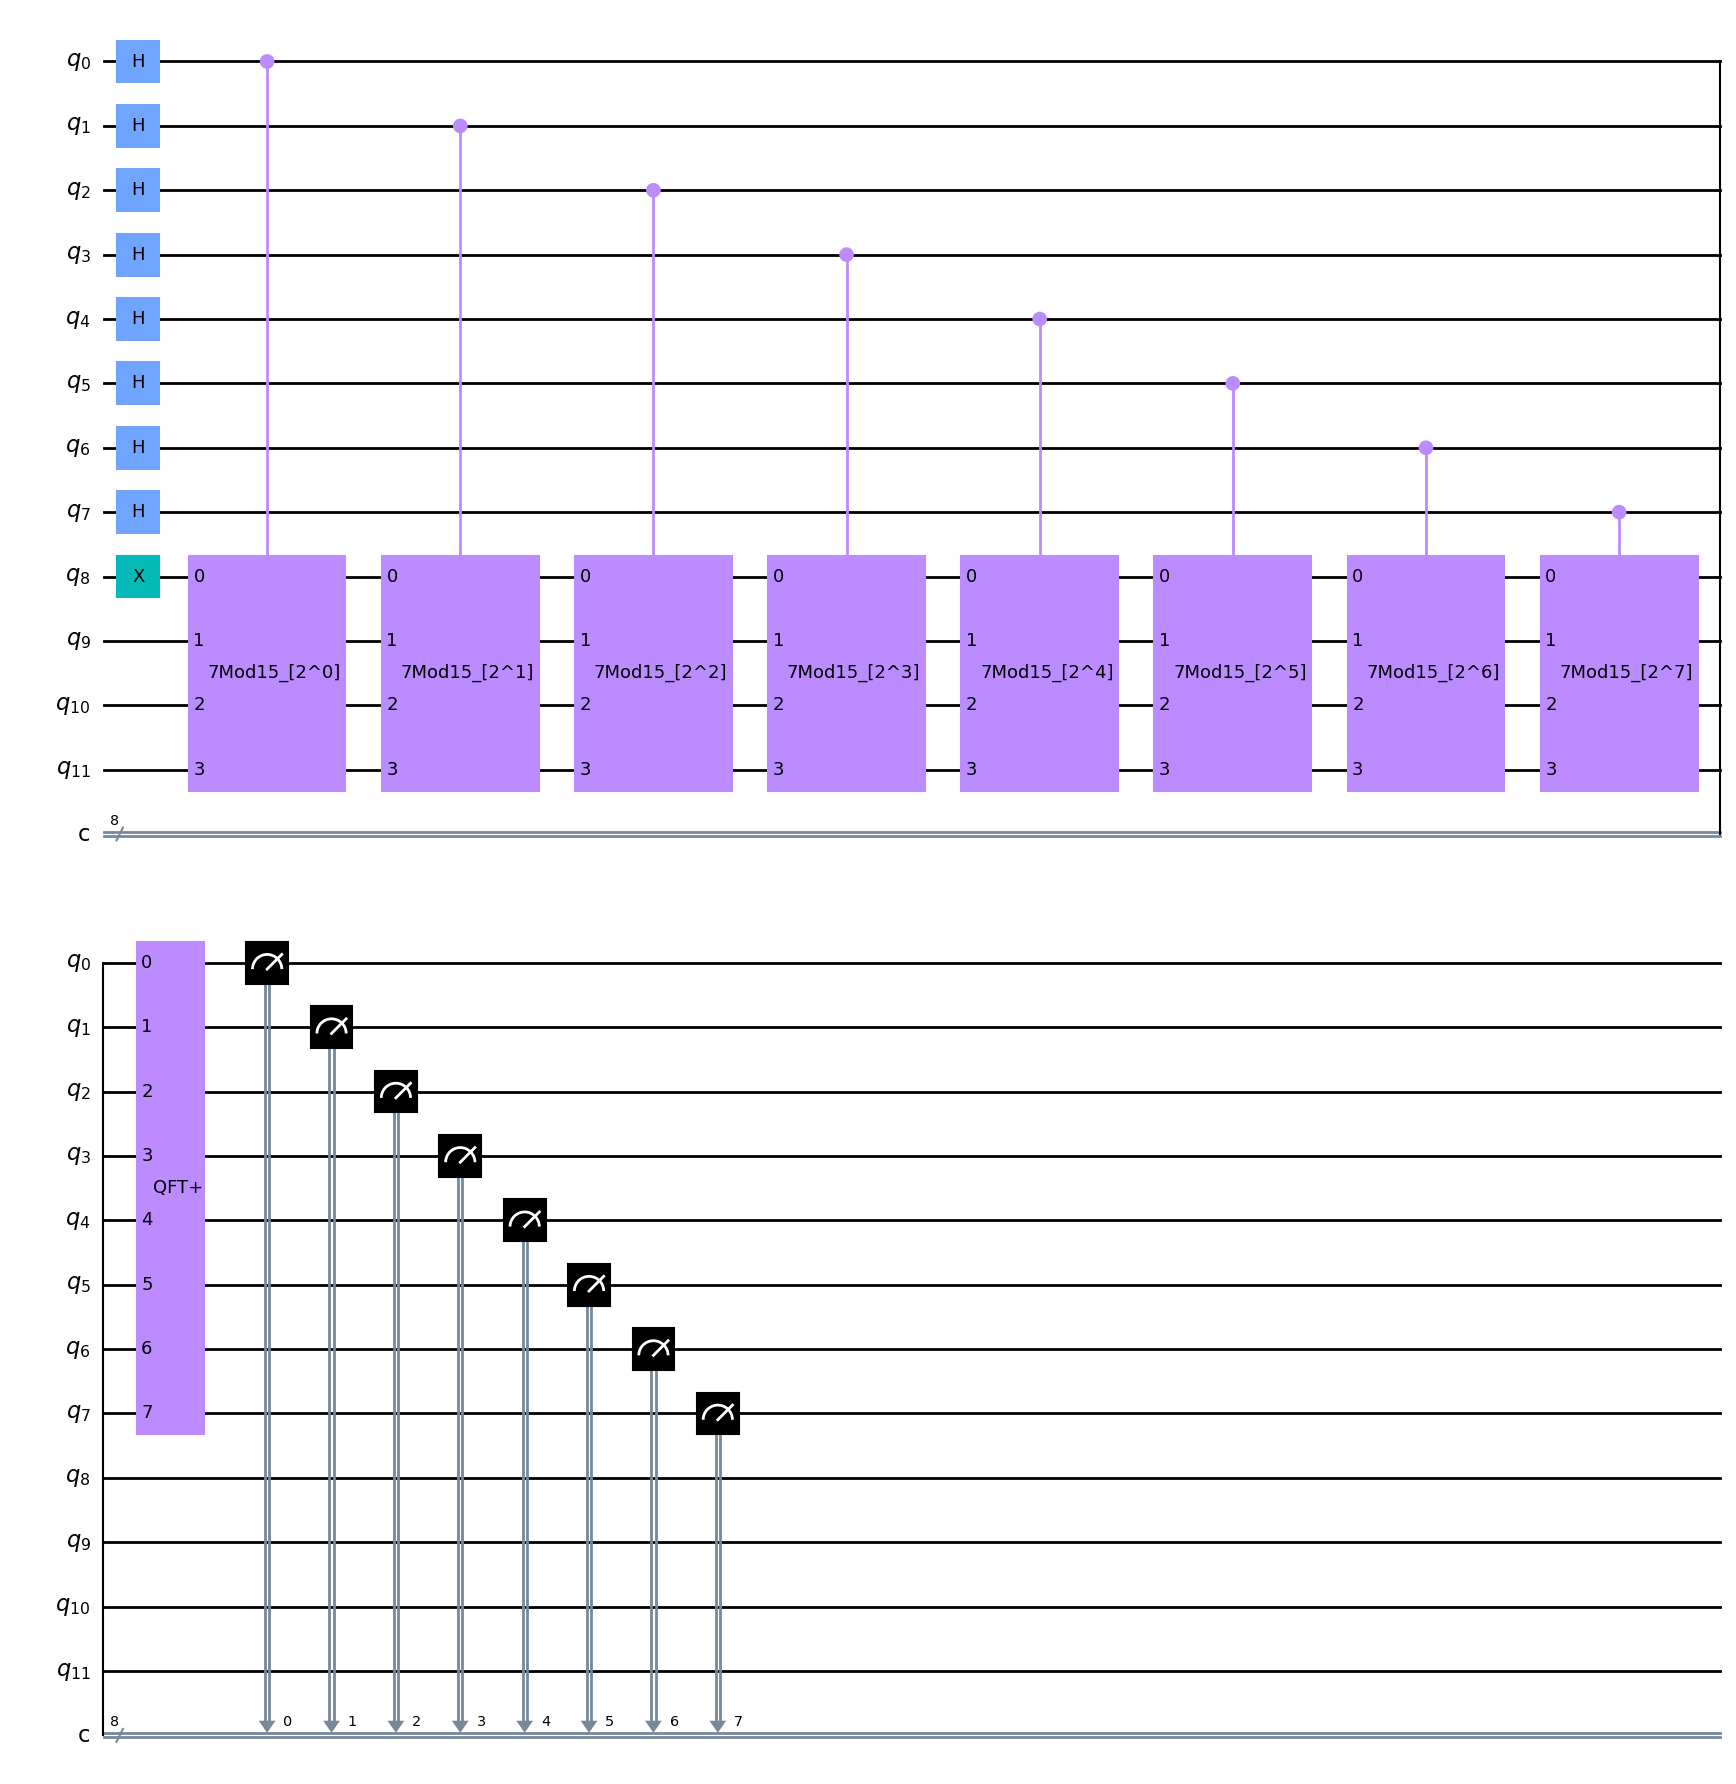

In [36]:
# QPE circuit for Shor
t = 8 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

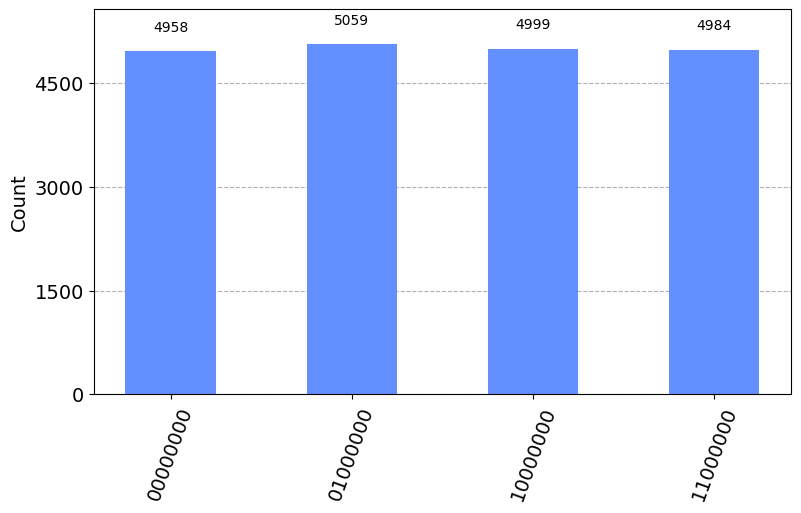

In [37]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000
count_QPE = execute(shor_QPE, sim, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**3) for key in count_QPE.keys()]
shor_qpe_counts = dict(zip(key_new, count_QPE.values()))
plot_histogram(count_QPE, figsize=(9,5))

In [38]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex7

grade_lab3_ex7(count_QPE)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


We can then find the integers $s$ and $r$ using the continued fractions algorithm.  Luckily python has built-in functionality for this using the `Fraction` function, where we will limit the denominator to $r<15$.  Use this to find the estimated $s$ and $r$ for each outcome you measured above.

In [39]:
import pandas as pd
from fractions import Fraction
print(Fraction(0.666), '\n')
print(Fraction(0.666).limit_denominator(15))

5998794703657501/9007199254740992 

2/3


In [40]:
rows, measured_phases = [], []
for output in count_QPE:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**t)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**t} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [41]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.25      1/4            4
2   0.00      0/1            1
3   0.50      1/2            2


In [42]:
frac

Fraction(1, 2)

In [43]:
outcomes = list(count_QPE.keys())
probabilities = list(count_QPE.values())

# Find the estimated s and r for each outcome using continued fractions algorithm
from fractions import Fraction
phase_fraction = []
for outcome in outcomes:
    phase_str = '0.' + outcome
    phase_fraction.append(Fraction(phase_str).limit_denominator(15))

print("Estimated s and r for each outcome:")
phase_fraction 

Estimated s and r for each outcome:


[Fraction(1, 9), Fraction(0, 1), Fraction(0, 1), Fraction(1, 10)]

In [44]:

shor_qpe_fractions =list[(1, 9), (1, 2), (0, 1), (1,4)] # create a list of Fraction objects for each measurement outcome


In [45]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex8

grade_lab3_ex8([Fraction(3, 4), Fraction(1, 2), Fraction(0, 1), Fraction(1, 4)])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 4. Putting it all together

Now let's put all of these steps together in order to factor the (very simple) number,  $N = 15$.  We'll continue with our example of $a=7$, remember that the phase we measure $s/r$ where $s$ is a random integer between $0$ and $r-1$ and:

$$
    a^r\text{mod}N = 1
$$

Then, once we have $r$, we can find a factor of $N$ by:

$$
    \left(a^r-1\right)\text{mod} N = 0
$$
which requires that $N$ must divide by $a^r-1$.  If $r$ is even, we can also write

$$
    a^r-1 = \left(a^{r/2}+1\right)\left(a^{r/2}-1\right).
$$

Put together a function called `shor_qpe` which takes an argument for $k$ (the number of counting qubits) and composes, runs, and processes Shor's algorithm to guess the factors.  Use an input state of $|y\rangle{}=|1\rangle{}$ for the phase estimation. (Note: The function `cU_multi()` only executes $|ay\ \text{mod}\ 15\rangle{}$ for $a=7$)

In [ ]:
def shor_qpe(k):
    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###


        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        ### Your code goes here ###


        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        ### Your code goes here ###


        #Step 3. Use the Fraction object to find the guess for r
        ### Your code goes here ###


        #Step 4. Now that r has been found, use the builtin greatest common deonominator
        # function to determine the guesses for a factor of N
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

        #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        # i.e.  (guess != 1 or N) and (N % guess == 0)
        ### Your code goes here ###
    
    #Step 6. If a nontrivial factor is found return the list 'guesses', otherwise
    # continue the while loop
    ### Your code goes here ###
    
    return guesses

In [1]:
from math import gcd
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from fractions import Fraction

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def qpe_amod15(a,k):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qc = QuantumCircuit(4+k, k)
    for q in range(k):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+k) # And auxiliary register in state |1>
    for q in range(k): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+k for i in range(4)])
    qc.append(qft_dagger(k), range(k)) # Do inverse-QFT
    qc.measure(range(k), range(k))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    phase = int(readings[0],2)/(2**k)
    return phase




# Test the function


In [5]:
a = 7
N = 15
def shor_qpe(k):
    ATTEMPT = 0
    FACTOR_FOUND = False
    while not FACTOR_FOUND:
        ATTEMPT += 1
        phase = qpe_amod15(a,k) # Phase = s/r
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0:
                    # Guess is a factor!
                    FACTOR_FOUND = True
    return guesses

In [9]:
k=4

In [17]:
!pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git@main

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git (to revision main) to /tmp/pip-req-build-wsrf3g5f
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-req-build-wsrf3g5f
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 2eb4d129f12d37c77dfc84f1144ede8e61e611d0
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [18]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.1
    Uninstalling pip-23.1.1:
      Successfully uninstalled pip-23.1.1
Note: you may need to restart the kernel to use updated packages.


In [11]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex9

grade_lab3_ex9(shor_qpe)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Congratulations! You've completed Lab 3 of the Global Summer School!! 🎉

This lab was adapted from both the [Qiskit QPE Lab](https://learn.qiskit.org/course/ch-labs/lab-5-accuracy-of-quantum-phase-estimation#lab-3-0) as well as the [Qiskit Shor's Algorithm](https://learn.qiskit.org/course/ch-labs/lab-7-scalable-shors-algorithm) lab